# Example: HCP MegaTrawl

In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scipy as sp

import networkx as nx

import dyneusr as ds

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper", "white")

%matplotlib inline

## Load data

In [4]:
from load_data import load_netmats, Bunch

# load data
data = load_netmats()

# show quick description
print()
print(data.data.shape, data.meta.shape)
print(data.X.shape, data.y.shape)

INFO:load_data:load_netmats(n_subjects=-1, n_runs=-1)
INFO:load_data:Loading data...
INFO:load_data:Loading data...
INFO:root: ** Encoding meta column: Gender



(1003, 225) (1003, 5)
(1003, 225) (1003, 5)


### Visual inspection of data, meta

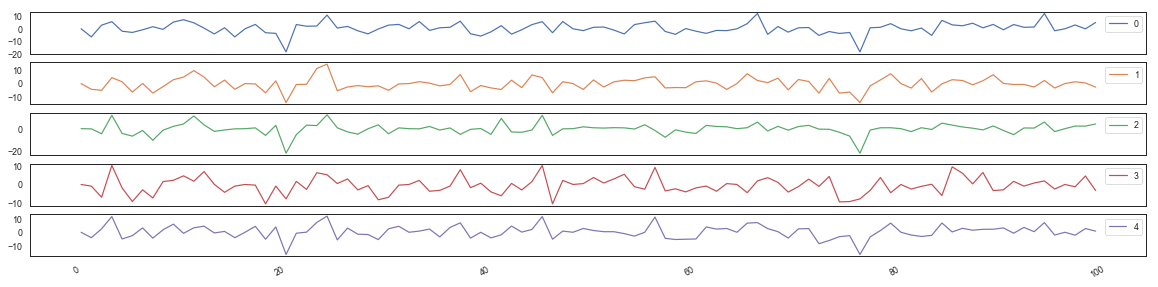

In [5]:
data.data.iloc[:5, :100].T.plot(figsize=(20,5), subplots=True)
plt.show()

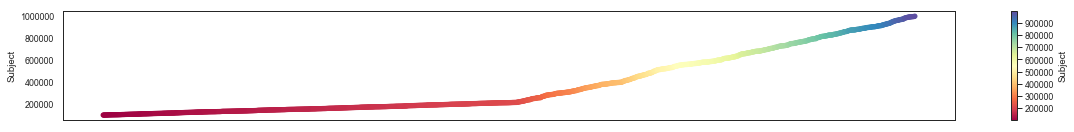

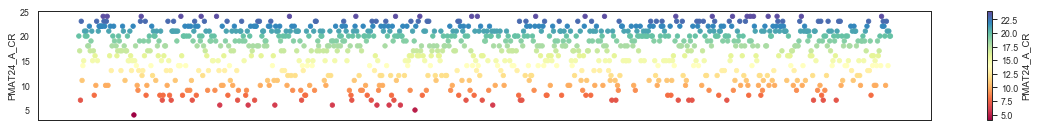

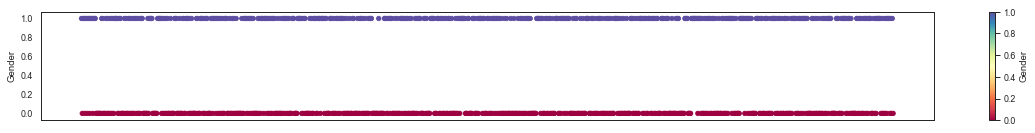

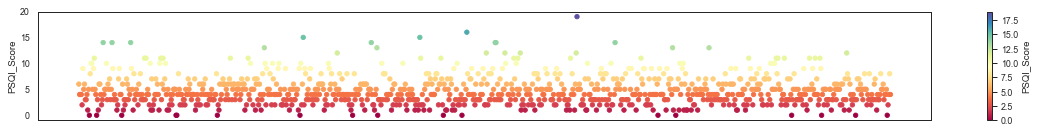

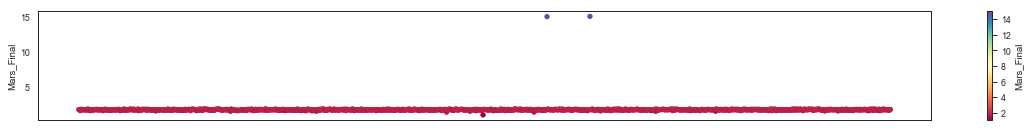

In [6]:
for col in data.meta.columns:
    data.meta.assign(index=data.meta.index).plot.scatter(
        x='index', y=col, c=col, cmap='Spectral',
        figsize=(20,2), subplots=True
    )
plt.show()

## Generate $MAPPER$ graph

In [7]:
# define inputs: X=data, y=meta
X = data.data.values
X_inverse = data.data.values

In [8]:
import kmapper as km
from sklearn.manifold import TSNE

# init MAPPER
mapper = km.KeplerMapper(verbose=1)

# init MAPPER params
projection = TSNE(perplexity=50, init='pca', random_state=0)
clusterer = km.cluster.KMeans(2)
cover = km.Cover(10, 0.5)

KeplerMapper()


In [9]:
# run MAPPER
lens = mapper.fit_transform(X, projection=projection)
graph = mapper.map(lens, X_inverse, clusterer, cover)

..Composing projection pipeline of length 1:
	Projections: TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=50,
   random_state=0, verbose=0)
	Distance matrices: False
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (1003, 225)

..Projecting data using: 
	TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=50,
   random_state=0, verbose=1)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1003 samples in 0.005s...
[t-SNE] Computed neighbors for 1003 samples in 0.437s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1003
[t-SNE] Computed conditional probabilities for sample 1003 / 1003
[t-SNE] Mean sigma: 11.252

### Visual inspection of lens

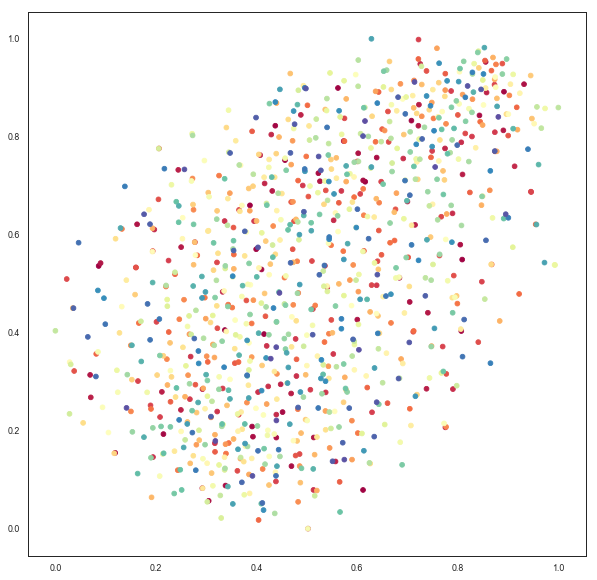

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(*lens.T, c=data.meta.index, cmap='Spectral')

## Fit a `DyNeuGraph` to the $MAPPER$ graph

Color by: 
- `Gender`
- `PMAT24_A_CR` (a.k.a. IQ)

In [11]:
y_col = 'Gender'
y = data.meta[y_col].values

# define y labels (optional)
labels = data.encoders[0][y_col].__dict__.get('classes_')
if labels is not None:
    print('labels:', labels)

labels: ['F' 'M']


In [12]:
# fit DyNeuGraph to MAPPER graph
dG = ds.DyNeuGraph()
dG.fit(graph, y=y, labels=labels)

# show shape of map_ (dimensions: nodes x members)
print()
print('dG.map_:', dG.map_.shape)
print('dG.G_.graph:', dG.G_.graph)

Found 2 unique groups.
1.0

dG.map_: (1003, 168)
dG.G_.graph: {'label': ['F', 'M'], 'groups': [0, 1]}


### Visual inspection of nx.Graph object

(<matplotlib.collections.PathCollection at 0x10c42a400>,
 <matplotlib.collections.LineCollection at 0x122677860>)

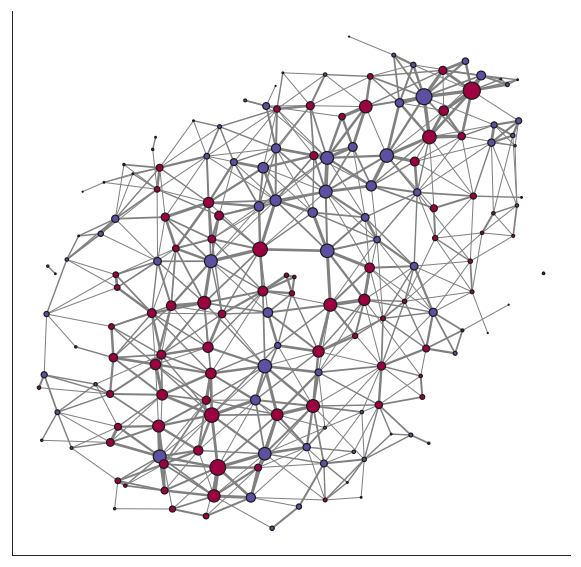

In [13]:
from collections import Counter
node_color = [Counter(y[dG.G_.nodes[n]['members']]).most_common()[0][0] for n in dG.G_]
node_size = [len(y[dG.G_.nodes[n]['members']])**1.5 for n in dG.G_]

# plot nx
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ds.tools.networkx_utils.draw_nx(
    dG.G_, lens=lens, pos="inverse", layout=None,
    node_size=node_size, node_color=node_color, 
    cmap='Spectral', ax=ax, 
    )

## Annotate Graph with images

In [14]:
import os
if not os.path.exists('results/tooltips'):
    os.makedirs('results/tooltips')

### Plot mean FC for each node

In [15]:
# tooltip for each dG.G_
tooltips = []
for i, n in enumerate(dG.G_):  
    # format path to save figure
    save_as = 'results/tooltips/mean_FC_node_{}.png'.format(n)
    tooltips.append(save_as)  
    
    # plot, if file does not already exists
    if os.path.exists(save_as):
        continue
        
    # get netmats for each node, compute mean FC
    members = dG.G_.nodes[n]['members']
    netmats = data.X[members].copy()
    mean_FC = netmats.mean(axis=0).reshape(15, 15)

    # plot mean fc    
    from nilearn.plotting import plot_matrix
    plot_matrix(mean_FC)
    plt.savefig(save_as, transparent=True)
    plt.close('all')
      
    # display progress
    if i%10 == 0:
        print("[{} of {}] Saved: {}".format(i, len(dG.G_), save_as))

# display progress
print('[done]')

[0 of 168] Saved: results/tooltips/mean_FC_node_cube1_cluster0.png
[10 of 168] Saved: results/tooltips/mean_FC_node_cube6_cluster1.png
[20 of 168] Saved: results/tooltips/mean_FC_node_cube14_cluster1.png
[30 of 168] Saved: results/tooltips/mean_FC_node_cube21_cluster1.png
[40 of 168] Saved: results/tooltips/mean_FC_node_cube26_cluster0.png
[50 of 168] Saved: results/tooltips/mean_FC_node_cube32_cluster1.png
[60 of 168] Saved: results/tooltips/mean_FC_node_cube37_cluster1.png
[70 of 168] Saved: results/tooltips/mean_FC_node_cube43_cluster1.png
[80 of 168] Saved: results/tooltips/mean_FC_node_cube48_cluster1.png
[90 of 168] Saved: results/tooltips/mean_FC_node_cube53_cluster1.png
[100 of 168] Saved: results/tooltips/mean_FC_node_cube58_cluster1.png
[110 of 168] Saved: results/tooltips/mean_FC_node_cube63_cluster1.png
[120 of 168] Saved: results/tooltips/mean_FC_node_cube68_cluster0.png
[130 of 168] Saved: results/tooltips/mean_FC_node_cube74_cluster0.png
[140 of 168] Saved: results/toolt

In [16]:
# annotate dG with images
_ = dG.annotate(image=tooltips)

## Visualize `DyNeuGraph`

In [17]:
%%script bash --bg

python3 -m http.server 8882

Starting job # 0 in a separate thread.


In [18]:
_ = dG.visualize('hcp_megatrawl.html', path_assets='results', show=True, PORT=8882)

0
1
[Force Graph] http://localhost:8882/hcp_megatrawl.html


<Figure size 432x288 with 0 Axes>